# SN II Template

Template from: https://github.com/maria-vincenzi/PyCoCo_templates/tree/master/Templates_HostCorrected

SN 2013by has a good **SN II** template

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import piscola

columns = ['phase', 'wave', 'flux']
name = '2013by'
sed_df = pd.read_csv(f'pycoco_SN{name}.SED', names=columns, delim_whitespace=True, comment='#')

## SED template

This SN II SED template has phases with respect to explosion epoch 

,phase,wave,flux
0,-9.28,1605.0,0.143
1,-9.28,1610.0,0.144
2,-9.28,1615.0,0.145
3,-9.28,1620.0,0.146
4,-9.28,1625.0,0.147


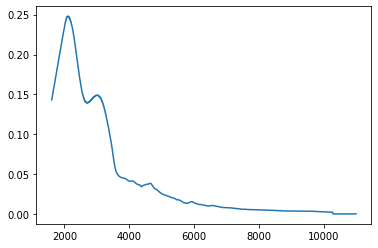

In [2]:
phase_df = sed_df[sed_df.phase==sed_df.phase.values[16]]
plt.plot(phase_df.wave, phase_df.flux);
sed_df.head()

## B-band peak

Let's get offset of the template phase to estimate a new phase with respect to B-band peak

In [3]:
Bessell_B = piscola.filters_class.SingleFilter('Bessell_B', 'VEGA')

fluxes_B = []
for phase in sed_df.phase.unique():
    phase_df = sed_df[sed_df.phase==phase]
    flux = Bessell_B.integrate_filter(phase_df.wave.values, phase_df.flux.values)
    fluxes_B.append(flux)
fluxes_B = np.array(fluxes_B)

(-15.0, 150.0)

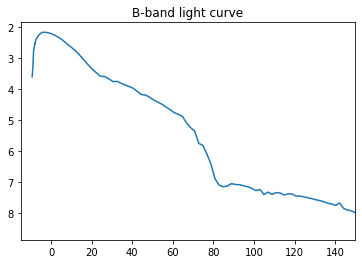

In [4]:
plt.plot(sed_df.phase.unique(), -2.5*np.log10(fluxes_B))
plt.gca().invert_yaxis()
plt.title('B-band light curve')
plt.xlim(-15, 150)

In [10]:
peak_id = np.argmax(fluxes_B)
peak_offset = sed_df.phase.unique()[peak_id]
peak_offset

-4.0

## Interpolate SED

In [11]:
interp_dict = {'phase':np.empty(0),
               'wave':np.empty(0),
               'flux':np.empty(0),
              }

waves = sed_df.wave.unique()
phases = sed_df.phase.unique()
interp_phases = np.arange(0, 200)

for wave in waves:
    lc_df = sed_df[sed_df.wave==wave]
    lc_phase, lc_flux = lc_df.phase.values, lc_df.flux.values
    interp_flux = np.interp(interp_phases, lc_phase, lc_flux)
    
    interp_wave = np.array([wave]*len(interp_phases))
    interp_dict['phase'] = np.append(interp_dict['phase'], interp_phases)
    interp_dict['wave'] = np.append(interp_dict['wave'], interp_wave)
    interp_dict['flux'] = np.append(interp_dict['flux'], interp_flux)
    
interp_df = pd.DataFrame(interp_dict)
interp_df.sort_values(['phase', 'wave'], inplace=True)
# apply offset to phase to have epochs with respect to B-band peak
# instead of epochs with respect to explosion epoch
interp_df.phase = interp_df.phase.values - peak_offset

,phase,wave,flux
0,4.0,1605.0,0.135
200,4.0,1610.0,0.135
400,4.0,1615.0,0.136
600,4.0,1620.0,0.136
800,4.0,1625.0,0.136


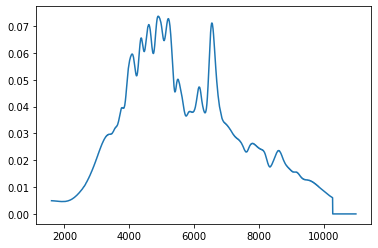

In [12]:
phase_df = interp_df[interp_df.phase==20]
plt.plot(phase_df.wave, phase_df.flux);
interp_df.head()

## Output

Save the template for PISCOLA to read and create a README file

In [12]:
interp_df.to_csv('sed_template.dat', index=False, sep='\t', header=False)

In [9]:
readme = f"""This template is a modified version of the PyCoCo SN II {name} template
taken from https://github.com/maria-vincenzi/PyCoCo_templates/tree/master/Templates_HostCorrected.

The original template is linearly interpolated in time and
the phases are shifted such that the Bessell-B-band light-curve
peak is taken as phase 0 (zero).
"""

In [10]:
with open('README.txt', 'w') as file:
    file.write(readme)